## Healthiest City

Data source: Healthy Lifestyle Cities Report 2021 from https://www.lenstore.co.uk/research/healthy-lifestyle-report/

**Research Topic:**

What does it mean to be the healthiest city?

**Research questions:**
1. Can cities with a high average of hours worked be healthy?
2. Do cities with more sunshine have more outdoor activities resulting in a healthier city?

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from empiricaldist import Pmf
from empiricaldist import Cdf
import scipy.stats
from scipy.stats import norm
import statsmodels.formula.api as smf

import thinkstats2
import thinkplot

pd.options.display.float_format = '{:.5f}'.format

In [2]:
healthy_df = pd.read_csv('healthy_lifestyle_city_2021.csv')

healthy_df.head()

,City,Rank,Sunshine hours(City),Cost of a bottle of water(City),Obesity levels(Country),Life expectancy(years) (Country),Pollution(Index score) (City),Annual avg. hours worked,Happiness levels(Country),Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City)
0,Amsterdam,1,1858,£1.92,20.40%,81.20000,30.93,1434,7.44000,422,1048,£34.90
1,Sydney,2,2636,£1.48,29.00%,82.10000,26.86,1712,7.22000,406,1103,£41.66
2,Vienna,3,1884,£1.94,20.10%,81.00000,17.33,1501,7.29000,132,1008,£25.74
3,Stockholm,4,1821,£1.72,20.60%,81.80000,19.63,1452,7.35000,129,598,£37.31
4,Copenhagen,5,1630,£2.19,19.70%,79.80000,21.24,1380,7.64000,154,523,£32.53


In [3]:
# Shape
healthy_df.shape

(44, 12)

In [4]:
# Data Types
healthy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   City                                    44 non-null     object 
 1   Rank                                    44 non-null     int64  
 2   Sunshine hours(City)                    44 non-null     object 
 3   Cost of a bottle of water(City)         44 non-null     object 
 4   Obesity levels(Country)                 44 non-null     object 
 5   Life expectancy(years) (Country)        44 non-null     float64
 6   Pollution(Index score) (City)           44 non-null     object 
 7   Annual avg. hours worked                44 non-null     object 
 8   Happiness levels(Country)               44 non-null     float64
 9   Outdoor activities(City)                44 non-null     int64  
 10  Number of take out places(City)         44 non-null     int64  


## Data Cleaning

Sunshine hours, Cost of a bottle of water, Obesity levels, Pollution, Annual Hours Worked, and  
Cost of Monthly Gym Membership need to be converted to numeric

In [5]:
# Convert Cost of a bottle of water to US Dollars
rate_of_exchange = 1.31
df = dict()

df['Amount'] = healthy_df['Cost of a bottle of water(City)'].str[1:]
healthy_df['Cost of a bottle of water(City)'] = pd.to_numeric(df['Amount']) * rate_of_exchange
healthy_df['Cost of a bottle of water(City)'].head()

0   2.51520
1   1.93880
2   2.54140
3   2.25320
4   2.86890
Name: Cost of a bottle of water(City), dtype: float64

In [6]:
# Convert Cost of a monthly gym membership to US Dollars
rate_of_exchange = 1.31

df['Amount'] = healthy_df['Cost of a monthly gym membership(City)'].str[1:]
healthy_df['Cost of a monthly gym membership(City)'] = pd.to_numeric(df['Amount']) * rate_of_exchange
healthy_df['Cost of a monthly gym membership(City)'].head()

0   45.71900
1   54.57460
2   33.71940
3   48.87610
4   42.61430
Name: Cost of a monthly gym membership(City), dtype: float64

In [7]:
# Convert Obesity levels(Country) to float removing '%'
df['Obesity'] = healthy_df['Obesity levels(Country)'].str.replace("%", "")
healthy_df['Obesity levels(Country)'] = pd.to_numeric(df['Obesity'])
healthy_df['Obesity levels(Country)'].head()

0   20.40000
1   29.00000
2   20.10000
3   20.60000
4   19.70000
Name: Obesity levels(Country), dtype: float64

In [8]:
# Convert Sunshine Hours, Pollution, Annual avg. hours worked to numeric
healthy_df['Sunshine hours(City)'] = pd.to_numeric(healthy_df['Sunshine hours(City)'], errors = 'coerce', 
                                                   downcast = 'integer').fillna(0)
healthy_df['Pollution(Index score) (City)'] = pd.to_numeric(healthy_df['Pollution(Index score) (City)'], 
                                                            errors = 'coerce').fillna(0.0)
healthy_df['Annual avg. hours worked'] = pd.to_numeric(healthy_df['Annual avg. hours worked'], 
                                                        errors = 'coerce', downcast = 'integer').fillna(0)

In [9]:
# Convert Hours of Sunshine per year to hours per day
healthy_df["SunshinePerDay"] = round(healthy_df["Sunshine hours(City)"] /  360)

# Convert Annual Average hours Worked to hours per day
healthy_df["WorkPerDay"] = round(healthy_df["Annual avg. hours worked"] /  360)

In [10]:
# Renamne column headings
healthy_cleaned_df = healthy_df.rename({'Cost of a bottle of water(City)': 'water_cost', 
                                     'Obesity levels(Country)': 'obesity_levels',
                                    'Outdoor activities(City)': 'outdoor_activity',
                                     'Pollution(Index score) (City)': 'pollution',
                                      'Life expectancy(years) (Country)': 'life_expectancy' }, axis=1) 

In [11]:
# With new variables
healthy_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   City                                    44 non-null     object 
 1   Rank                                    44 non-null     int64  
 2   Sunshine hours(City)                    44 non-null     float64
 3   water_cost                              44 non-null     float64
 4   obesity_levels                          44 non-null     float64
 5   life_expectancy                         44 non-null     float64
 6   pollution                               44 non-null     float64
 7   Annual avg. hours worked                44 non-null     float64
 8   Happiness levels(Country)               44 non-null     float64
 9   outdoor_activity                        44 non-null     int64  
 10  Number of take out places(City)         44 non-null     int64  


## 5 Variables for Analysis

1. SunshinePerDay: Daily Sunshine hours per City
2. obesity_levels: Obesity levels per Country
3. water_cost: Cost of a bottle of water per City
4. outdoor_activity: Number of outdoor activities per City
5. WorkPerDay: Daily average hours worked
6. pollution: Polution index per City
7. life_expectancy: Life expectancy per Country

In [12]:
healthy_cleaned_df[['SunshinePerDay', 'water_cost', 'obesity_levels', 'WorkPerDay', 'outdoor_activity',
                   'pollution', 'life_expectancy']].head()

,SunshinePerDay,water_cost,obesity_levels,WorkPerDay,outdoor_activity,pollution,life_expectancy
0,5.00000,2.51520,20.40000,4.00000,422,30.93000,81.20000
1,7.00000,1.93880,29.00000,5.00000,406,26.86000,82.10000
2,5.00000,2.54140,20.10000,4.00000,132,17.33000,81.00000
3,5.00000,2.25320,20.60000,4.00000,129,19.63000,81.80000
4,5.00000,2.86890,19.70000,4.00000,154,21.24000,79.80000


## EDA

In [13]:
def findOutliers_IQR(df):
    '''
    Find Outliers in the dataframe
    
    args:
        df (dataframe)
        
    return:
        outliers (dataframe)
    '''
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    outliers = df[((df <= lower_bound) | (df >= upper_bound))]
    
    return outliers

## Histogram and outliers of each of the 5 variables and how to deal with the outliers

### Daily Hours of Sunshine Analysis

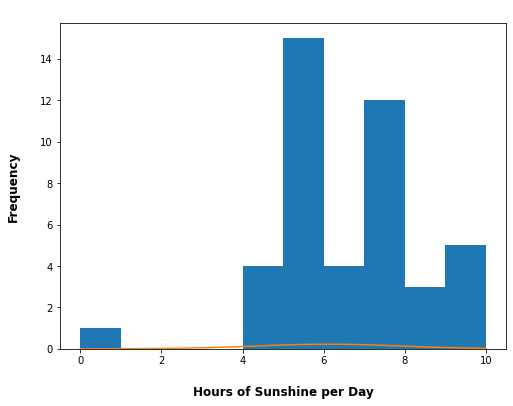

In [14]:
# Histogram
hoursSunshine_hist = healthy_cleaned_df.hist(column = 'SunshinePerDay', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['SunshinePerDay'])

hoursSunshine_hist = hoursSunshine_hist[0]

min = np.min(healthy_cleaned_df['SunshinePerDay'])
max = np.max(healthy_cleaned_df['SunshinePerDay'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Hours of Sunshine per Day", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [15]:
print(f"Mode: {healthy_df['SunshinePerDay'].mode()}")
print(f"Median: {healthy_df['SunshinePerDay'].median()}")
print(f"Std Dev: {healthy_df['SunshinePerDay'].std()}")
print(f"Skew: {pd.DataFrame(healthy_df['SunshinePerDay']).skew()[0]}")

Mode: 0   5.00000
Name: SunshinePerDay, dtype: float64
Median: 6.0
Std Dev: 1.8199911715976667
Skew: -0.41876879423351593


In [16]:
healthy_cleaned_df['SunshinePerDay'].describe()

count   44.00000
mean     6.11364
std      1.81999
min      0.00000
25%      5.00000
50%      6.00000
75%      7.00000
max     10.00000
Name: SunshinePerDay, dtype: float64

In [17]:
outliers = findOutliers_IQR(healthy_cleaned_df['SunshinePerDay'])
print(f"Number of outliers for Sunshine hours: {str(len(outliers))}")
print(f"Max outlier for Sunshine hours: {str(outliers.max())}")
print(f"Min outlier for Sunshine hours: {str(outliers.min())}")

print(f"Outliers are: \n{outliers}")

Number of outliers for Sunshine hours: 2
Max outlier for Sunshine hours: 10.0
Min outlier for Sunshine hours: 0.0
Outliers are: 
19    0.00000
22   10.00000
Name: SunshinePerDay, dtype: float64


The spread is from the minimum to the maximum which is 10 hrs
Since the mean and median are the same there are no tails

*The outlier in this column is 0. As no city has 0 hours of sunshine per year I believe this to be a typo and
the outlier should be removed from the data. A city can have 10 hours of sunshine so this piece of data should stay*

In [18]:
# Create a CDF
# Remove water cost > $4.00
sunshine_filtered = healthy_cleaned_df[healthy_cleaned_df['SunshinePerDay'] > 0]
sunshine_filtered.shape

(43, 14)

In [19]:
sunshine_cdf = Cdf.from_seq(sunshine_filtered['SunshinePerDay'])
sunshine_cdf.head()

,probs
4.00000,0.09302
5.00000,0.44186
6.00000,0.53488


# of Hours of Sunshine per Day at Probability of 25%: 5.0 hrs
# of Hours of Sunshine per Day at Probability of 50%: 6.0 hrs
# of Hours of Sunshine per Day at Probability of 75%: 7.0 hrs


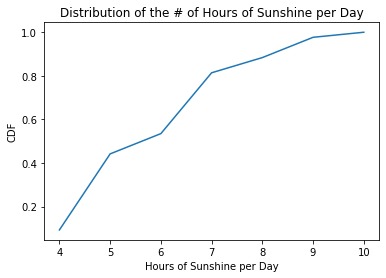

In [20]:
sunshine_cdf.plot()
plt.xlabel('Hours of Sunshine per Day')
plt.ylabel('CDF')
plt.title('Distribution of the # of Hours of Sunshine per Day')

print(f"# of Hours of Sunshine per Day at Probability of 25%: {sunshine_cdf.inverse(0.25)} hrs")
print(f"# of Hours of Sunshine per Day at Probability of 50%: {sunshine_cdf.inverse(0.5)} hrs")
print(f"# of Hours of Sunshine per Day at Probability of 75%: {sunshine_cdf.inverse(0.75)} hrs")

### Obsesity Levels per Country Analysis

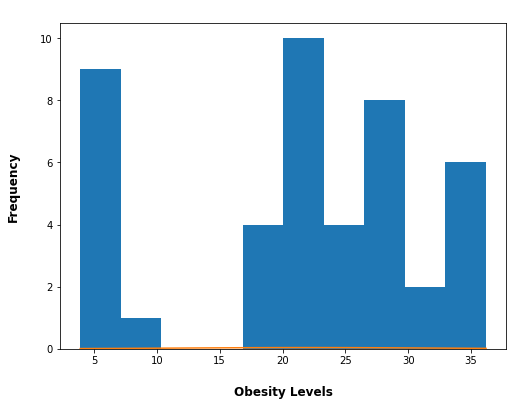

In [21]:
# Histogram
obesityLevel_hist = healthy_cleaned_df.hist(column = 'obesity_levels', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['obesity_levels'])

obesityLevel_hist = obesityLevel_hist[0]

min = np.min(healthy_cleaned_df['obesity_levels'])
max = np.max(healthy_cleaned_df['obesity_levels'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Obesity Levels", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [22]:
print(f"Mode: {healthy_cleaned_df['obesity_levels'].mode()}")
print(f"Median: {healthy_cleaned_df['obesity_levels'].median()}")
print(f"Std Dev: {healthy_cleaned_df['obesity_levels'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['obesity_levels']).skew()[0]}")

Mode: 0   36.20000
Name: obesity_levels, dtype: float64
Median: 22.3
Std Dev: 10.195669965554575
Skew: -0.4679912673634951


In [23]:
healthy_cleaned_df['obesity_levels'].describe()

count   44.00000
mean    21.92500
std     10.19567
min      3.90000
25%     19.50000
50%     22.30000
75%     29.00000
max     36.20000
Name: obesity_levels, dtype: float64

In [24]:
outliers = findOutliers_IQR(healthy_cleaned_df['obesity_levels'])
print(f"Number of outliers for Obesity Levels: {str(len(outliers))}")
print(f"Max outlier for Obesity Levels: {str(outliers.max())}")
print(f"Min outlier for Obesity Levels: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for Obesity Levels: 4
Max outlier for Obesity Levels: 4.7
Min outlier for Obesity Levels: 3.9
Outliers are: 
6    4.30000
17   4.70000
25   3.90000
28   4.30000
Name: obesity_levels, dtype: float64


*There are 4 outliers in this column.  They seem to be far from the mean so we can safely remove them but there can be cities with very low obesity levels so keeping them wouldnt be out of the question*

In [25]:
# Create a CDF
obesity_cdf = Cdf.from_seq(healthy_cleaned_df['obesity_levels'])
obesity_cdf.head()

,probs
3.90000,0.02273
4.30000,0.06818
4.70000,0.09091


Obesity Levels per Country at Probability of 25%: 19.5
Obesity Levels per Country at Probability of 50%: 22.3
Obesity Levels per Country at Probability of 75%: 29.0


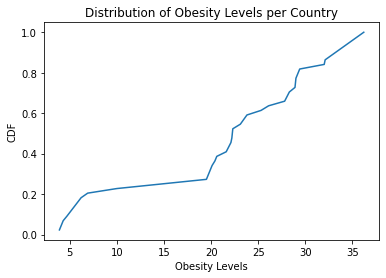

In [26]:
obesity_cdf.plot()
plt.xlabel('Obesity Levels')
plt.ylabel('CDF')
plt.title('Distribution of Obesity Levels per Country')

print(f"Obesity Levels per Country at Probability of 25%: {obesity_cdf.inverse(0.25)}")
print(f"Obesity Levels per Country at Probability of 50%: {obesity_cdf.inverse(0.5)}")
print(f"Obesity Levels per Country at Probability of 75%: {obesity_cdf.inverse(0.75)}")

### Cost of a bottle of water Analysis

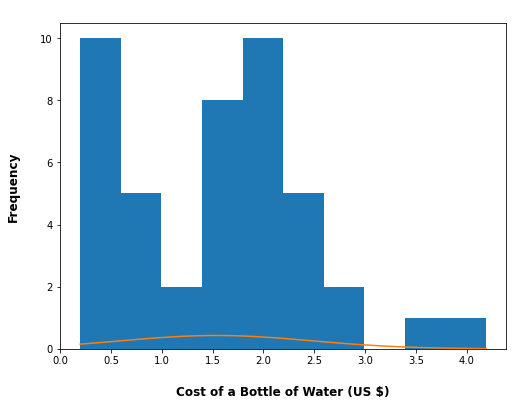

In [27]:
# Histogram
waterCost_hist = healthy_cleaned_df.hist(column = 'water_cost', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['water_cost'])

obesityLevel_hist = obesityLevel_hist[0]

min = np.min(healthy_cleaned_df['water_cost'])
max = np.max(healthy_cleaned_df['water_cost'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Cost of a Bottle of Water (US $)", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [28]:
print(f"Mode: {healthy_cleaned_df['water_cost'].mode()}")
print(f"Median: {healthy_cleaned_df['water_cost'].median()}")
print(f"Std Dev: {healthy_cleaned_df['water_cost'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['water_cost']).skew()[0]}")

Mode: 0   0.19650
1   0.74670
2   0.77290
3   2.09600
4   2.55450
Name: water_cost, dtype: float64
Median: 1.56545
Std Dev: 0.9414209499951933
Skew: 0.46042661471361096


In [29]:
healthy_cleaned_df['water_cost'].describe()

count   44.00000
mean     1.53717
std      0.94142
min      0.19650
25%      0.74670
50%      1.56545
75%      2.09600
max      4.19200
Name: water_cost, dtype: float64

In [30]:
outliers = findOutliers_IQR(healthy_cleaned_df['water_cost'])
print(f"Number of outliers for water cost: {str(len(outliers))}")
print(f"Max outlier for water cost: {str(outliers.max())}")
print(f"Min outlier for water cost: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for water cost: 1
Max outlier for water cost: 4.192
Min outlier for water cost: 4.192
Outliers are: 
36   4.19200
Name: water_cost, dtype: float64


*There is one outlier of \\$4.19 for a bottle of water. Since the mean is \\$1.52 I this we can be safe to remove this
outlier and just a very expensive city*

In [31]:
# Remove water cost > $4.00
waterCost_filtered = healthy_cleaned_df[healthy_cleaned_df['water_cost'] < 4]
waterCost_filtered.shape

(43, 14)

In [32]:
# Cost of a bottle of water(City)
waterCost_cdf = Cdf.from_seq(waterCost_filtered['water_cost'])
waterCost_cdf.head()

,probs
0.19650,0.04651
0.20960,0.06977
0.27510,0.09302


Cost of a Bottle of Water at Probability of 25%: $0.7466999999999999
Cost of a Bottle of Water at Probability of 50%: $1.5589
Cost of a Bottle of Water at Probability of 75%: $2.096


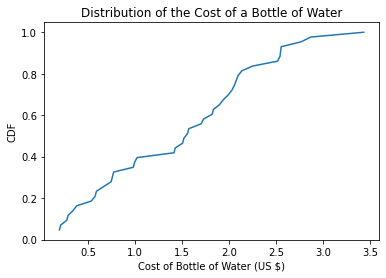

In [33]:
waterCost_cdf.plot()
plt.xlabel('Cost of Bottle of Water (US $)')
plt.ylabel('CDF')
plt.title('Distribution of the Cost of a Bottle of Water')

print(f"Cost of a Bottle of Water at Probability of 25%: ${waterCost_cdf.inverse(0.25)}")
print(f"Cost of a Bottle of Water at Probability of 50%: ${waterCost_cdf.inverse(0.5)}")
print(f"Cost of a Bottle of Water at Probability of 75%: ${waterCost_cdf.inverse(0.75)}")

### Outdoor activities(City) Analysis

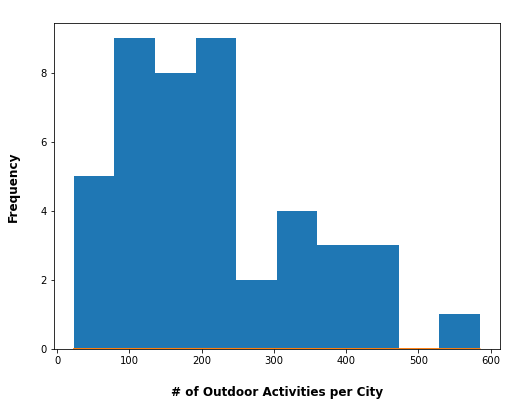

In [34]:
# Histogram
outdoor_hist = healthy_cleaned_df.hist(column = 'outdoor_activity', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['outdoor_activity'])

outdoor_hist = outdoor_hist[0]

min = np.min(healthy_cleaned_df['outdoor_activity'])
max = np.max(healthy_cleaned_df['outdoor_activity'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("# of Outdoor Activities per City", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [35]:
print(f"Mode: {healthy_cleaned_df['outdoor_activity'].mode()}")
print(f"Median: {healthy_cleaned_df['outdoor_activity'].median()}")
print(f"Std Dev: {healthy_cleaned_df['outdoor_activity'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['outdoor_activity']).skew()[0]}")

Mode: 0    223
Name: outdoor_activity, dtype: int64
Median: 189.5
Std Dev: 127.19029666009126
Skew: 0.7927788840317203


In [36]:
healthy_cleaned_df['outdoor_activity'].describe()

count    44.00000
mean    213.97727
std     127.19030
min      23.00000
25%     125.25000
50%     189.50000
75%     288.25000
max     585.00000
Name: outdoor_activity, dtype: float64

In [37]:
outliers = findOutliers_IQR(healthy_cleaned_df['outdoor_activity'])
print(f"Number of outliers for outdoor activities: {str(len(outliers))}")
print(f"Max outlier for outdoor activities: {str(outliers.max())}")
print(f"Min outlier for outdoor activities: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for outdoor activities: 1
Max outlier for outdoor activities: 585
Min outlier for outdoor activities: 585
Outliers are: 
8    585
Name: outdoor_activity, dtype: int64


*There are 1 outlier having a whopping 585 number of outdoor activites.  As the mean is 214, I think we can safely remove this one city*

In [38]:
# Create a CDF
# Remove # > 580
outdoor_filtered = healthy_cleaned_df[healthy_cleaned_df['outdoor_activity'] < 580]
outdoor_filtered.shape

(43, 14)

In [39]:
outdoor_cdf = Cdf.from_seq(outdoor_filtered['outdoor_activity'])
outdoor_cdf.head()

,probs
23,0.02326
35,0.04651
44,0.06977


# of Outdoor Activities per City at Probability of 25%: 114.0
# of Outdoor Activities per City at Probability of 50%: 187.0
# of Outdoor Activities per City at Probability of 75%: 277.0


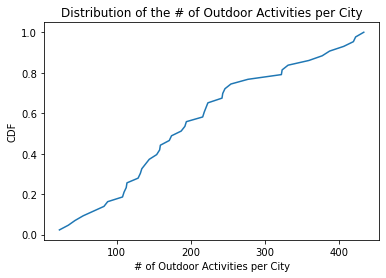

In [40]:
outdoor_cdf.plot()
plt.xlabel('# of Outdoor Activities per City')
plt.ylabel('CDF')
plt.title('Distribution of the # of Outdoor Activities per City')

print(f"# of Outdoor Activities per City at Probability of 25%: {outdoor_cdf.inverse(0.25)}")
print(f"# of Outdoor Activities per City at Probability of 50%: {outdoor_cdf.inverse(0.5)}")
print(f"# of Outdoor Activities per City at Probability of 75%: {outdoor_cdf.inverse(0.75)}")

### Daily Average houred Worked Analysis

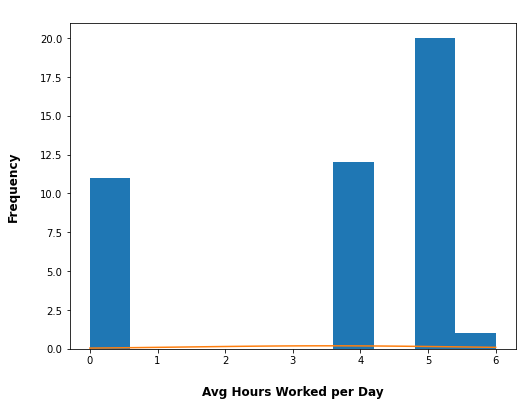

In [41]:
# Histogram
hoursWorked_hist = healthy_cleaned_df.hist(column = 'WorkPerDay', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['WorkPerDay'])

hoursWorked_hist = hoursWorked_hist[0]

min = np.min(healthy_cleaned_df['WorkPerDay'])
max = np.max(healthy_cleaned_df['WorkPerDay'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Avg Hours Worked per Day", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [42]:
print(f"Mode: {healthy_cleaned_df['WorkPerDay'].mode()}")
print(f"Median: {healthy_cleaned_df['WorkPerDay'].median()}")
print(f"Std Dev: {healthy_cleaned_df['WorkPerDay'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['WorkPerDay']).skew()[0]}")

Mode: 0   5.00000
Name: WorkPerDay, dtype: float64
Median: 4.0
Std Dev: 2.0965087257651236
Skew: -1.0231890238236054


In [43]:
healthy_cleaned_df['WorkPerDay'].describe(include  = 'all')

count   44.00000
mean     3.50000
std      2.09651
min      0.00000
25%      3.00000
50%      4.00000
75%      5.00000
max      6.00000
Name: WorkPerDay, dtype: float64

In [44]:
outliers = findOutliers_IQR(healthy_cleaned_df['WorkPerDay'])
print(f"Number of outliers for Avg Hours Worked: {str(len(outliers))}")
print(f"Max outlier for Avg Hours Worked: {str(outliers.max())}")
print(f"Min outlier for Avg Hours Worked: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for Avg Hours Worked: 11
Max outlier for Avg Hours Worked: 0.0
Min outlier for Avg Hours Worked: 0.0
Outliers are: 
11   0.00000
12   0.00000
13   0.00000
16   0.00000
22   0.00000
23   0.00000
25   0.00000
30   0.00000
31   0.00000
35   0.00000
38   0.00000
Name: WorkPerDay, dtype: float64


*A lot of the cities has 0 daily hours of work but since this is an average this needs to stay in the dataset*

In [45]:
# Create a CDF
work_cdf = Cdf.from_seq(healthy_cleaned_df['WorkPerDay'])
work_cdf.head()

,probs
0.00000,0.25000
4.00000,0.52273
5.00000,0.97727


#Avg # of hours Worked per Day at Probability of 25%: 0.0
Avg # of hours Worked per Day at Probability of 50%: 4.0
Avg # of hours Worked per Day at Probability of 75%: 5.0


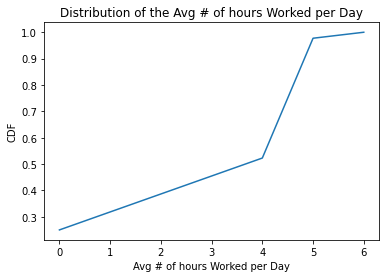

In [46]:
work_cdf.plot()
plt.xlabel('Avg # of hours Worked per Day')
plt.ylabel('CDF')
plt.title('Distribution of the Avg # of hours Worked per Day')

print(f"#Avg # of hours Worked per Day at Probability of 25%: {work_cdf.inverse(0.25)}")
print(f"Avg # of hours Worked per Day at Probability of 50%: {work_cdf.inverse(0.5)}")
print(f"Avg # of hours Worked per Day at Probability of 75%: {work_cdf.inverse(0.75)}")

### Pollution

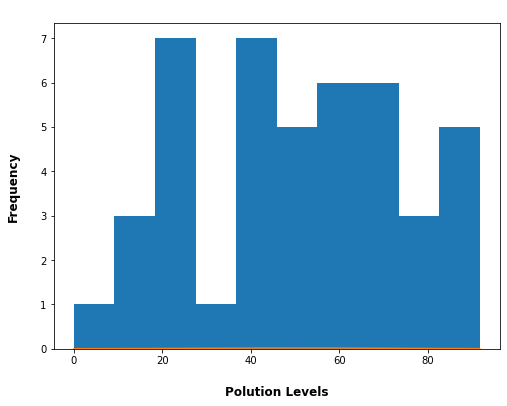

In [47]:
# Histogram
pollution_hist = healthy_cleaned_df.hist(column = 'pollution', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['pollution'])

pollution_hist = pollution_hist[0]

min = np.min(healthy_cleaned_df['pollution'])
max = np.max(healthy_cleaned_df['pollution'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Polution Levels", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [48]:
print(f"Mode: {healthy_cleaned_df['pollution'].mode()}")
print(f"Median: {healthy_cleaned_df['pollution'].median()}")
print(f"Std Dev: {healthy_cleaned_df['pollution'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['pollution']).skew()[0]}")

Mode: 0     0.00000
1    13.08000
2    17.31000
3    17.33000
4    19.63000
5    21.24000
6    24.26000
7    25.90000
8    26.86000
9    27.03000
10   27.25000
11   30.93000
12   37.78000
13   37.83000
14   39.18000
15   39.41000
16   40.07000
17   42.84000
18   43.33000
19   47.28000
20   47.36000
21   49.32000
22   52.64000
23   52.68000
24   57.36000
25   57.63000
26   57.82000
27   58.91000
28   61.83000
29   62.67000
30   65.10000
31   65.19000
32   66.07000
33   67.19000
34   67.46000
35   69.49000
36   76.64000
37   77.40000
38   79.78000
39   82.78000
40   82.84000
41   84.39000
42   85.43000
43   91.74000
Name: pollution, dtype: float64
Median: 50.980000000000004
Std Dev: 22.934285490317205
Skew: -0.09538055579913667


In [49]:
healthy_cleaned_df['pollution'].describe(include  = 'all')

count   44.00000
mean    49.96045
std     22.93429
min      0.00000
25%     30.01000
50%     50.98000
75%     66.35000
max     91.74000
Name: pollution, dtype: float64

In [50]:
outliers = findOutliers_IQR(healthy_cleaned_df['pollution'])
print(f"Number of outliers for Pollution Index: {str(len(outliers))}")
print(f"Max outlier for Pollution: {str(outliers.max())}")
print(f"Min outlier for Pollution: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for Pollution Index: 0
Max outlier for Pollution: nan
Min outlier for Pollution: nan
Outliers are: 
Series([], Name: pollution, dtype: float64)


*There are no outliers for pollution*

In [51]:
# Create a CDF
pollution_cdf = Cdf.from_seq(healthy_cleaned_df['pollution'])
pollution_cdf.head()

,probs
0.00000,0.02273
13.08000,0.04545
17.31000,0.06818


Pollution Levels per City at Probability of 25%: 27.25
Pollution Levels per City of 50%: 49.32
Pollution Levels per City at Probability of 75%: 66.07


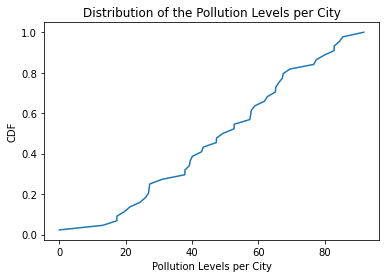

In [52]:
pollution_cdf.plot()
plt.xlabel('Pollution Levels per City')
plt.ylabel('CDF')
plt.title('Distribution of the Pollution Levels per City')

print(f"Pollution Levels per City at Probability of 25%: {pollution_cdf.inverse(0.25)}")
print(f"Pollution Levels per City of 50%: {pollution_cdf.inverse(0.5)}")
print(f"Pollution Levels per City at Probability of 75%: {pollution_cdf.inverse(0.75)}")

### Life Expectancy

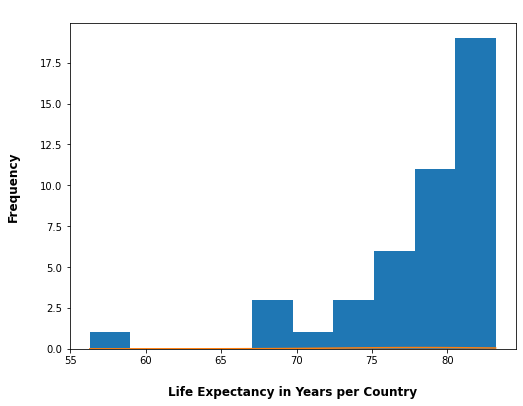

In [53]:
# Histogram
lifeExpectancy_hist = healthy_cleaned_df.hist(column = 'life_expectancy', figsize = (8,6), grid = False)
mu, std = norm.fit (healthy_cleaned_df['life_expectancy'])

lifeExpectancy_hist = lifeExpectancy_hist[0]

min = np.min(healthy_cleaned_df['life_expectancy'])
max = np.max(healthy_cleaned_df['life_expectancy'])
domain = np.linspace(min, max)

plt.plot(domain, norm.pdf(domain, mu, std))
plt.xlabel("Life Expectancy in Years per Country", labelpad=20, weight='bold', size=12)
plt.ylabel("Frequency", labelpad=20, weight='bold', size=12)
plt.title(" ")

plt.show()

In [54]:
print(f"Mode: {healthy_cleaned_df['life_expectancy'].mode()}")
print(f"Median: {healthy_cleaned_df['life_expectancy'].median()}")
print(f"Std Dev: {healthy_cleaned_df['life_expectancy'].std()}")
print(f"Skew: {pd.DataFrame(healthy_cleaned_df['life_expectancy']).skew()[0]}")

Mode: 0   78.80000
Name: life_expectancy, dtype: float64
Median: 80.4
Std Dev: 5.3043696335476405
Skew: -2.098348326667041


In [55]:
healthy_cleaned_df['life_expectancy'].describe(include  = 'all')

count   44.00000
mean    78.17500
std      5.30437
min     56.30000
25%     75.40000
50%     80.40000
75%     81.80000
max     83.20000
Name: life_expectancy, dtype: float64

In [56]:
outliers = findOutliers_IQR(healthy_cleaned_df['life_expectancy'])
print(f"Number of outliers for Life Expectancy: {str(len(outliers))}")
print(f"Max outlier for Life Expectancy: {str(outliers.max())}")
print(f"Min outlier for Life Expectancy: {str(outliers.min())}")
print(f"Outliers are: \n{outliers}")

Number of outliers for Life Expectancy: 1
Max outlier for Life Expectancy: 56.3
Min outlier for Life Expectancy: 56.3
Outliers are: 
38   56.30000
Name: life_expectancy, dtype: float64


*There is 1 outlier at 56.3 years old but I think we should leave it as it could be valid*

In [57]:
# Create a CDF
life_cdf = Cdf.from_seq(healthy_cleaned_df['life_expectancy'])
life_cdf.head()

,probs
56.30000,0.02273
67.30000,0.04545
68.50000,0.06818


Life Expectancy per Country (Years) at Probability of 25%: 75.4
Life Expectancy per Country (Years) of 50%: 80.4
PLife Expectancy per Country (Years) at Probability of 75%: 81.8


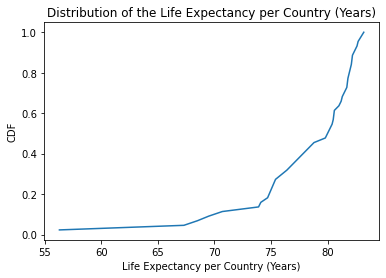

In [58]:
life_cdf.plot()
plt.xlabel('Life Expectancy per Country (Years)')
plt.ylabel('CDF')
plt.title('Distribution of the Life Expectancy per Country (Years)')

print(f"Life Expectancy per Country (Years) at Probability of 25%: {life_cdf.inverse(0.25)}")
print(f"Life Expectancy per Country (Years) of 50%: {life_cdf.inverse(0.5)}")
print(f"PLife Expectancy per Country (Years) at Probability of 75%: {life_cdf.inverse(0.75)}")

## Compare Two Scenarios using a PMF for the Same Variable

In [59]:
### Compare Obesity Levels from the number of hours per day of Sunshine

In [60]:
# Remove Sunshine per Day hours less than 5
sunshine_filtered = healthy_cleaned_df[healthy_cleaned_df['SunshinePerDay'] > 1]
sunshine_filtered.head()

,City,Rank,Sunshine hours(City),water_cost,obesity_levels,life_expectancy,pollution,Annual avg. hours worked,Happiness levels(Country),outdoor_activity,Number of take out places(City),Cost of a monthly gym membership(City),SunshinePerDay,WorkPerDay
0,Amsterdam,1,1858.00000,2.51520,20.40000,81.20000,30.93000,1434.00000,7.44000,422,1048,45.71900,5.00000,4.00000
1,Sydney,2,2636.00000,1.93880,29.00000,82.10000,26.86000,1712.00000,7.22000,406,1103,54.57460,7.00000,5.00000
2,Vienna,3,1884.00000,2.54140,20.10000,81.00000,17.33000,1501.00000,7.29000,132,1008,33.71940,5.00000,4.00000
3,Stockholm,4,1821.00000,2.25320,20.60000,81.80000,19.63000,1452.00000,7.35000,129,598,48.87610,5.00000,4.00000
4,Copenhagen,5,1630.00000,2.86890,19.70000,79.80000,21.24000,1380.00000,7.64000,154,523,42.61430,5.00000,4.00000


In [61]:
# Get the unique values of the number of hours
sunshine_filtered["SunshinePerDay"].value_counts().sort_index()

4.00000      4
5.00000     15
6.00000      4
7.00000     12
8.00000      3
9.00000      4
10.00000     1
Name: SunshinePerDay, dtype: int64

### Compare the highest frequency of 5 hours compares to the rest for obesity levels

In [62]:
# Create df for 5 hours of sunshine and non 5 hours of sunshine
obesity_hours5 = sunshine_filtered[sunshine_filtered.SunshinePerDay == 5]
print(obesity_hours5['obesity_levels'].value_counts().sort_index())

obesity_rest = sunshine_filtered[sunshine_filtered.SunshinePerDay != 5]
print(obesity_rest['obesity_levels'].value_counts().sort_index())

4.30000     1
6.20000     2
19.70000    1
19.90000    1
20.10000    1
20.40000    1
20.60000    1
21.60000    1
22.20000    1
22.30000    2
23.10000    1
27.80000    1
29.40000    1
Name: obesity_levels, dtype: int64
3.90000     1
4.30000     1
4.70000     1
6.20000     2
6.90000     1
10.00000    1
19.50000    1
22.10000    2
23.80000    2
25.30000    1
26.10000    1
28.30000    2
28.90000    1
29.00000    2
29.40000    1
32.00000    1
32.10000    1
36.20000    6
Name: obesity_levels, dtype: int64


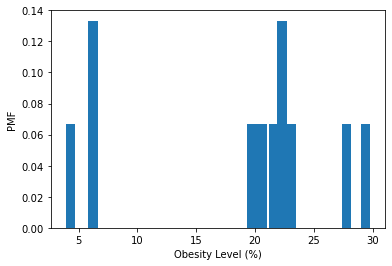

In [63]:
# Plot the PMF levels of 5 hours of Sunshine
obesity_5hrs_pmf = Pmf.from_seq(obesity_hours5['obesity_levels'])
plt.xlabel("Obesity Level (%)")
plt.ylabel("PMF")
obesity_5hrs_pmf.bar()

Mean obesity of 5 hours of Sunshine: 19.07333333333333
Mean obesity of Rest of Sunshine: 23.53928571428571


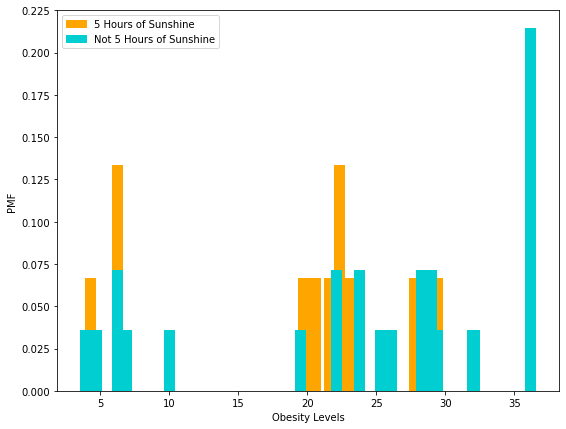

In [64]:
# Compare the PMF of Obesity Level in 5 hours vs the rest
obesity_5hrs_pmf = Pmf.from_seq(obesity_hours5['obesity_levels'])
obesity_rest_pmf = Pmf.from_seq(obesity_rest['obesity_levels'])

fig, ax = plt.subplots(1, 1, figsize = (9, 7))

fiveHours = mpatches.Patch(color='orange', label='5 Hours of Sunshine')
rest = mpatches.Patch(color='darkturquoise', label='Not 5 Hours of Sunshine')
ax.legend(handles=[fiveHours, rest ], )

plt.xlabel("Obesity Levels")
plt.ylabel("PMF")

obesity_5hrs_pmf.bar(color=['orange'])
obesity_rest_pmf.bar(color=['darkturquoise'])

# Save figure for powerpoint
plt.savefig('Obesity Levels per Hours of Sunshine.png')

print(f"Mean obesity of 5 hours of Sunshine: {obesity_5hrs_pmf.mean()}")
print(f"Mean obesity of Rest of Sunshine: {obesity_rest_pmf.mean()}")

*With 5 hours of sunshine the obesity levels are much lower than any other amount of sunshine per day*

### Analytical Distribution and provide analysis on how it applies to the dataset

In [65]:
# Obesity levels(Country)
# Normal Probablity Plot

In [66]:
# remove outliers from obesity levels
obesity_filtered = healthy_cleaned_df[healthy_cleaned_df['obesity_levels'] > 4.7]
obesity_filtered.head()

,City,Rank,Sunshine hours(City),water_cost,obesity_levels,life_expectancy,pollution,Annual avg. hours worked,Happiness levels(Country),outdoor_activity,Number of take out places(City),Cost of a monthly gym membership(City),SunshinePerDay,WorkPerDay
0,Amsterdam,1,1858.00000,2.51520,20.40000,81.20000,30.93000,1434.00000,7.44000,422,1048,45.71900,5.00000,4.00000
1,Sydney,2,2636.00000,1.93880,29.00000,82.10000,26.86000,1712.00000,7.22000,406,1103,54.57460,7.00000,5.00000
2,Vienna,3,1884.00000,2.54140,20.10000,81.00000,17.33000,1501.00000,7.29000,132,1008,33.71940,5.00000,4.00000
3,Stockholm,4,1821.00000,2.25320,20.60000,81.80000,19.63000,1452.00000,7.35000,129,598,48.87610,5.00000,4.00000
4,Copenhagen,5,1630.00000,2.86890,19.70000,79.80000,21.24000,1380.00000,7.64000,154,523,42.61430,5.00000,4.00000


((array([-2.11583547, -1.7314906 , -1.50271646, -1.33321868, -1.19520249,
         -1.07683093, -0.97189321, -0.87669641, -0.78885043, -0.70670905,
         -0.62908229, -0.55507545, -0.48399287, -0.41527745, -0.34847074,
         -0.28318561, -0.2190868 , -0.15587657, -0.09328369, -0.03105452,
          0.03105452,  0.09328369,  0.15587657,  0.2190868 ,  0.28318561,
          0.34847074,  0.41527745,  0.48399287,  0.55507545,  0.62908229,
          0.70670905,  0.78885043,  0.87669641,  0.97189321,  1.07683093,
          1.19520249,  1.33321868,  1.50271646,  1.7314906 ,  2.11583547]),
  array([ 6.2,  6.2,  6.2,  6.2,  6.9, 10. , 19.5, 19.5, 19.7, 19.9, 20.1,
         20.4, 20.6, 21.6, 22.1, 22.1, 22.2, 22.3, 22.3, 23.1, 23.8, 23.8,
         25.3, 26.1, 27.8, 28.3, 28.3, 28.9, 29. , 29. , 29.4, 29.4, 32. ,
         32.1, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2])),
 (8.831800285405313, 23.6875, 0.9599328594932077))

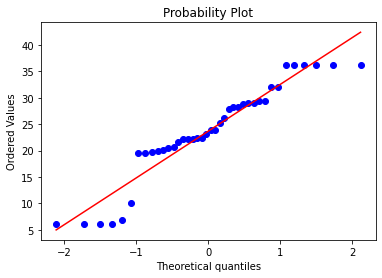

In [67]:
scipy.stats.probplot(obesity_filtered['obesity_levels'], dist="norm", plot = plt)

The probability plot suggests that the distribution of Obesity weights does not really follow a normal distribution.

## Create 2 scatterplots comparing two variables and provide analysis on correlation and causation

### Is the obesity levels in a city related to the number of hours of sunshine?

In [68]:
# Remove Sunshine per Day hours less than 1
sunshine_filtered = healthy_cleaned_df[healthy_cleaned_df['SunshinePerDay'] > 1]
sunshine_filtered.head()

,City,Rank,Sunshine hours(City),water_cost,obesity_levels,life_expectancy,pollution,Annual avg. hours worked,Happiness levels(Country),outdoor_activity,Number of take out places(City),Cost of a monthly gym membership(City),SunshinePerDay,WorkPerDay
0,Amsterdam,1,1858.00000,2.51520,20.40000,81.20000,30.93000,1434.00000,7.44000,422,1048,45.71900,5.00000,4.00000
1,Sydney,2,2636.00000,1.93880,29.00000,82.10000,26.86000,1712.00000,7.22000,406,1103,54.57460,7.00000,5.00000
2,Vienna,3,1884.00000,2.54140,20.10000,81.00000,17.33000,1501.00000,7.29000,132,1008,33.71940,5.00000,4.00000
3,Stockholm,4,1821.00000,2.25320,20.60000,81.80000,19.63000,1452.00000,7.35000,129,598,48.87610,5.00000,4.00000
4,Copenhagen,5,1630.00000,2.86890,19.70000,79.80000,21.24000,1380.00000,7.64000,154,523,42.61430,5.00000,4.00000


<AxesSubplot:xlabel='obesity_levels', ylabel='SunshinePerDay'>

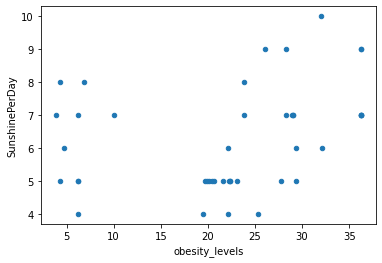

In [69]:
sunshine_filtered.plot.scatter(x = 'obesity_levels', y = 'SunshinePerDay')

Text(0, 0.5, 'Hours of Sunshine per Day')

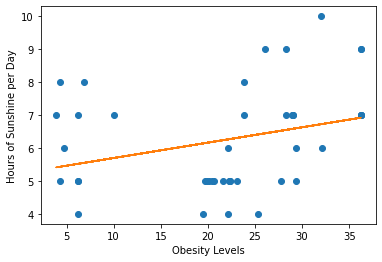

In [70]:
# scatterplot with regression line
plt.plot(sunshine_filtered['obesity_levels'], sunshine_filtered['SunshinePerDay'], 'o')
m, b = np.polyfit(sunshine_filtered['obesity_levels'], sunshine_filtered['SunshinePerDay'], 1)

plt.plot(sunshine_filtered['obesity_levels'], m * sunshine_filtered['obesity_levels'] + b)

plt.xlabel("Obesity Levels")
plt.ylabel("Hours of Sunshine per Day")

Looking at the scatterplot, it doesnt look like there is a correlation between obesity levels and the number of hours of sunshine per day a city has.

In [71]:
# Pearson's Correlation Coefficient

healthy_pearson1 = scipy.stats.pearsonr(sunshine_filtered['obesity_levels'], sunshine_filtered['SunshinePerDay'])
print(f"Pearsons: {healthy_pearson1}")

Pearsons: (0.30530096045489086, 0.046501372852199206)


In [72]:
# R squared
healthy_pearson1[0]**2

0.09320867645467883

Looking at the coefficent and r-squared values, it suggests that there is no correlation between the number of hours of sunshine and obesity levels in a healthy city.  The p-value is significant.

### Is the number of outdoor activities related to the cost of a bottle of water?

In [73]:
# Remove Water Cost > $4.00 and number of activities > 580
filtered_1 = healthy_cleaned_df[healthy_cleaned_df['water_cost'] < 4]
filtered_1 = healthy_cleaned_df[healthy_cleaned_df['outdoor_activity'] < 580]
filtered_1.head()

,City,Rank,Sunshine hours(City),water_cost,obesity_levels,life_expectancy,pollution,Annual avg. hours worked,Happiness levels(Country),outdoor_activity,Number of take out places(City),Cost of a monthly gym membership(City),SunshinePerDay,WorkPerDay
0,Amsterdam,1,1858.00000,2.51520,20.40000,81.20000,30.93000,1434.00000,7.44000,422,1048,45.71900,5.00000,4.00000
1,Sydney,2,2636.00000,1.93880,29.00000,82.10000,26.86000,1712.00000,7.22000,406,1103,54.57460,7.00000,5.00000
2,Vienna,3,1884.00000,2.54140,20.10000,81.00000,17.33000,1501.00000,7.29000,132,1008,33.71940,5.00000,4.00000
3,Stockholm,4,1821.00000,2.25320,20.60000,81.80000,19.63000,1452.00000,7.35000,129,598,48.87610,5.00000,4.00000
4,Copenhagen,5,1630.00000,2.86890,19.70000,79.80000,21.24000,1380.00000,7.64000,154,523,42.61430,5.00000,4.00000


<AxesSubplot:xlabel='water_cost', ylabel='outdoor_activity'>

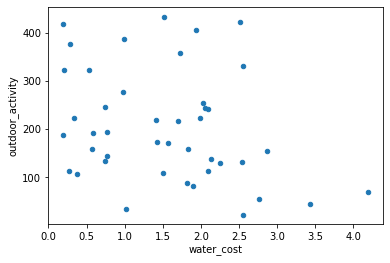

In [74]:
filtered_1.plot.scatter(x = 'water_cost', y = 'outdoor_activity')

Text(0, 0.5, 'Number of Outdoor Activities')

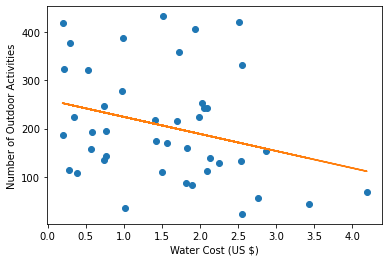

In [75]:
# scatterplot with regression line
plt.plot(filtered_1['water_cost'], filtered_1['outdoor_activity'], 'o')
m, b = np.polyfit(filtered_1['water_cost'], filtered_1['outdoor_activity'], 1)

plt.plot(filtered_1['water_cost'], m * filtered_1['water_cost'] + b)

plt.xlabel("Water Cost (US $)")
plt.ylabel("Number of Outdoor Activities")

In [76]:
# Pearson's Correlation Coefficient

healthy_pearson2 = scipy.stats.pearsonr(filtered_1['water_cost'], 
                                       filtered_1['outdoor_activity'])
print(f"Pearsons: {healthy_pearson2}")

Pearsons: (-0.29327152526484096, 0.056307833686462465)


Looking at the coefficent and r-squared values, it suggests that there is no correlation between the cost of a bottle of water and the number of outdoor activities in a healthy city.  The p-value is significant.

In [77]:
# R squared
healthy_pearson2[0]**2

0.08600818753116625

### Conduct a test on your hypothesis

### Hypothesis:

Distributions between obesity levels for 5 hours of sunshine and rest are the same

In [78]:
obesity_hours5['obesity_levels'].describe()

count   15.00000
mean    19.07333
std      7.52097
min      4.30000
25%     19.80000
50%     20.60000
75%     22.30000
max     29.40000
Name: obesity_levels, dtype: float64

In [79]:
obesity_rest['obesity_levels'].describe()

count   28.00000
mean    23.53929
std     11.34833
min      3.90000
25%     17.12500
50%     27.20000
75%     32.02500
max     36.20000
Name: obesity_levels, dtype: float64

In [80]:
scipy.stats.ttest_ind(obesity_hours5['obesity_levels'], obesity_rest['obesity_levels'], equal_var = True)

Ttest_indResult(statistic=-1.3678184807504605, pvalue=0.1788197915489945)

## Regression

Test each of the chosen variables helps determine obesity levels in a healthy city

In [81]:
# Remove Outliers: number of activities > 580, sunshine per day < 1, water cost > 4
filtered = healthy_cleaned_df[healthy_cleaned_df['outdoor_activity'] < 580]
filtered = healthy_cleaned_df[healthy_cleaned_df['SunshinePerDay'] > 1]
filtered = healthy_cleaned_df[healthy_cleaned_df['water_cost'] < 4]

filtered.head()

,City,Rank,Sunshine hours(City),water_cost,obesity_levels,life_expectancy,pollution,Annual avg. hours worked,Happiness levels(Country),outdoor_activity,Number of take out places(City),Cost of a monthly gym membership(City),SunshinePerDay,WorkPerDay
0,Amsterdam,1,1858.00000,2.51520,20.40000,81.20000,30.93000,1434.00000,7.44000,422,1048,45.71900,5.00000,4.00000
1,Sydney,2,2636.00000,1.93880,29.00000,82.10000,26.86000,1712.00000,7.22000,406,1103,54.57460,7.00000,5.00000
2,Vienna,3,1884.00000,2.54140,20.10000,81.00000,17.33000,1501.00000,7.29000,132,1008,33.71940,5.00000,4.00000
3,Stockholm,4,1821.00000,2.25320,20.60000,81.80000,19.63000,1452.00000,7.35000,129,598,48.87610,5.00000,4.00000
4,Copenhagen,5,1630.00000,2.86890,19.70000,79.80000,21.24000,1380.00000,7.64000,154,523,42.61430,5.00000,4.00000


In [82]:
# Average Hours Worked per Day per City
results_work = smf.ols('obesity_levels ~ WorkPerDay', data = filtered).fit()
results_work.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     12.06
Date:                Tue, 31 May 2022   Prob (F-statistic):            0.00123
Time:                        19:05:56   Log-Likelihood:                -155.29
No. Observations:                  43   AIC:                             314.6
Df Residuals:                      41   BIC:                             318.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8938      2.717      5.114      0.000       8.407      19.380
WorkPerDay     2.3184      0.668      3.473      0.001       0.970       3.667
==============================================================================
Omnibus:                        1.781   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.040
Skew:                          -0.361   Prob(JB):                        0.595
Kurtosis:                       3.246   Cond. No.                         8.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# Average Hours of Sunshine per Day per City
results_sunshine = smf.ols('obesity_levels ~ SunshinePerDay', 
                  data = filtered).fit()
results_sunshine.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.436
Date:                Tue, 31 May 2022   Prob (F-statistic):             0.0710
Time:                        19:05:57   Log-Likelihood:                -159.10
No. Observations:                  43   AIC:                             322.2
Df Residuals:                      41   BIC:                             325.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.2303      5.478      2.232      0.031       1.167      23.294
SunshinePerDay     1.5823      0.854      1.854      0.071      -0.142       3.306
==============================================================================
Omnibus:                        5.044   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                4.765
Skew:                          -0.761   Prob(JB):                       0.0923
Kurtosis:                       2.414   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
# Cost of a Bottle of Water per City
results_water = smf.ols('obesity_levels ~ water_cost', 
                  data = filtered).fit()
results_water.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     5.482
Date:                Tue, 31 May 2022   Prob (F-statistic):             0.0242
Time:                        19:05:57   Log-Likelihood:                -158.13
No. Observations:                  43   AIC:                             320.3
Df Residuals:                      41   BIC:                             323.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8912      3.000      5.297      0.000       9.833      21.950
water_cost     4.1277      1.763      2.341      0.024       0.567       7.688
==============================================================================
Omnibus:                       12.007   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                2.869
Skew:                          -0.016   Prob(JB):                        0.238
Kurtosis:                       1.735   Cond. No.                         4.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
# Number of Outdoor Activities per City
results_activity = smf.ols('obesity_levels ~ outdoor_activity', 
                  data = filtered).fit()
results_activity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8941
Date:                Tue, 31 May 2022   Prob (F-statistic):              0.350
Time:                        19:05:57   Log-Likelihood:                -160.37
No. Observations:                  43   AIC:                             324.7
Df Residuals:                      41   BIC:                             328.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.3975      3.154      6.151      0.000      13.029      25.766
outdoor_activity     0.0119      0.013      0.946      0.350      -0.014       0.037
==============================================================================
Omnibus:                        3.301   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                2.487
Skew:                          -0.439   Prob(JB):                        0.288
Kurtosis:                       2.215   Cond. No.                         503.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
# Multiple regression
results_activity = smf.ols('obesity_levels ~ WorkPerDay + SunshinePerDay + water_cost + outdoor_activity + pollution + life_expectancy', data = filtered).fit()
results_activity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     6.179
Date:                Tue, 31 May 2022   Prob (F-statistic):           0.000158
Time:                        19:05:57   Log-Likelihood:                -145.61
No. Observations:                  43   AIC:                             305.2
Df Residuals:                      36   BIC:                             317.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           51.5163     28.079      1.835      0.075      -5.431     108.464
WorkPerDay           2.7105      0.842      3.221      0.003       1.004       4.417
SunshinePerDay       1.9460      0.762      2.552      0.015       0.400       3.492
water_cost           6.4887      2.119      3.063      0.004       2.192      10.786
outdoor_activity     0.0109      0.010      1.057      0.297      -0.010       0.032
pollution            0.0487      0.076      0.642      0.525      -0.105       0.203
life_expectancy     -0.8376      0.353     -2.374      0.023      -1.553      -0.122
==============================================================================
Omnibus:                        0.094   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.298
Skew:                           0.045   Prob(JB):                        0.862
Kurtosis:                       2.603   Cond. No.                     6.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
# Nonlinear regression
filtered['life_expectancy2'] = filtered.life_expectancy ** 2
results_activity = smf.ols('obesity_levels ~ WorkPerDay + SunshinePerDay + water_cost + outdoor_activity + pollution + life_expectancy + life_expectancy2', data = filtered).fit()
results_activity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         obesity_levels   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     6.707
Date:                Tue, 31 May 2022   Prob (F-statistic):           4.60e-05
Time:                        19:05:57   Log-Likelihood:                -142.54
No. Observations:                  43   AIC:                             301.1
Df Residuals:                      35   BIC:                             315.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -277.6320    144.503     -1.921      0.063    -570.989      15.725
WorkPerDay           3.0677      0.810      3.789      0.001       1.424       4.711
SunshinePerDay       2.1085      0.723      2.915      0.006       0.640       3.577
water_cost           7.8192      2.082      3.756      0.001       3.593      12.045
outdoor_activity     0.0130      0.010      1.334      0.191      -0.007       0.033
pollution           -0.0069      0.076     -0.091      0.928      -0.160       0.147
life_expectancy      8.6493      4.108      2.106      0.042       0.310      16.989
life_expectancy2    -0.0675      0.029     -2.317      0.026      -0.127      -0.008
==============================================================================
Omnibus:                        0.675   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.710
Skew:                           0.040   Prob(JB):                        0.701
Kurtosis:                       2.376   Cond. No.                     7.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""